<a href="https://colab.research.google.com/github/mannat244/ML_Lab/blob/main/Copy_of_CUDA_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1. Matrix Addition
5 and 7 on CPU vs GPU

In [8]:
%%writefile matrix_add.cpp
#include <iostream>
#include <chrono>
#include <iomanip>
using namespace std;
using namespace std::chrono;

int main() {
    int r, c;
    cin >> r >> c;

    int A[r][c], B[r][c], C[r][c];

    for(int i = 0; i < r; i++)
        for(int j = 0; j < c; j++)
            A[i][j] = 5, B[i][j] = 7;

    auto start = high_resolution_clock::now();

    for(int i = 0; i < r; i++)
        for(int j = 0; j < c; j++)
            C[i][j] = A[i][j] + B[i][j];

    auto end = high_resolution_clock::now();

    // Print partial output
    for(int i = 0; i < r && i < 5; i++) {
        for(int j = 0; j < c && j < 5; j++)
            cout << C[i][j] << " ";
        cout << endl;
    }

    double time_ms = duration<double, milli>(end - start).count();

    cout << fixed << setprecision(4);
    cout << "Time: " << time_ms << " ms\n";

    return 0;
}


Overwriting matrix_add.cpp


CUDA Matrix Addition

In [3]:
%%writefile matrix_add.cu
#include <stdio.h>
#include <cuda.h>

__global__ void matrixAdd(int *A, int *B, int *C, int r, int c) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < c && y < r) {
        int idx = y * c + x;
        C[idx] = A[idx] + B[idx];
    }
}

int main() {
    int r, c;
    scanf("%d %d", &r, &c);

    int size = r * c * sizeof(int);

    int *hA = (int*)malloc(size);
    int *hB = (int*)malloc(size);
    int *hC = (int*)malloc(size);

    for(int i = 0; i < r*c; i++) {
        hA[i] = 5;
        hB[i] = 7;
    }

    int *dA, *dB, *dC;
    cudaMalloc(&dA, size);
    cudaMalloc(&dB, size);
    cudaMalloc(&dC, size);

    cudaMemcpy(dA, hA, size, cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, size, cudaMemcpyHostToDevice);

    dim3 threads(16,16);
    dim3 blocks((c+15)/16, (r+15)/16);

    // ---- CUDA timing ----
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    matrixAdd<<<blocks, threads>>>(dA, dB, dC, r, c);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float time_ms;
    cudaEventElapsedTime(&time_ms, start, stop);
    // ---------------------

    cudaMemcpy(hC, dC, size, cudaMemcpyDeviceToHost);

    // Print partial output
    for(int i = 0; i < r && i < 5; i++) {
        for(int j = 0; j < c && j < 5; j++)
            printf("%d ", hC[i*c + j]);
        printf("\n");
    }

    printf("GPU Time: %f ms\n", time_ms);

    cudaFree(dA); cudaFree(dB); cudaFree(dC);
    free(hA); free(hB); free(hC);

    return 0;
}


Writing matrix_add.cu


In [34]:
!g++ matrix_add.cpp -o matrix_add
!echo "250 250" | ./matrix_add


12 12 12 12 12 
12 12 12 12 12 
12 12 12 12 12 
12 12 12 12 12 
12 12 12 12 12 
Time: 0.1938 ms


In [35]:
!nvcc -arch=sm_75 matrix_add.cu -o matrix_add
!echo "250 250" | ./matrix_add

12 12 12 12 12 
12 12 12 12 12 
12 12 12 12 12 
12 12 12 12 12 
12 12 12 12 12 
GPU Time: 0.122656 ms


Results

input 10 10

cpu
Time: 0.0007 ms

GPU Time:  0.116736 ms

input 50 50

cpu Time: 0.0125 ms
GPU Time: 0.132128 ms

input 100 100
cpu Time: 0.0370 ms
GPU Time: 0.106432 ms

input 200 200
cpu Time: 0.1163 ms
GPU Time: 0.113120 ms

input 250 250
cpu Time: 0.1938 ms
GPU Time: 0.122656 ms




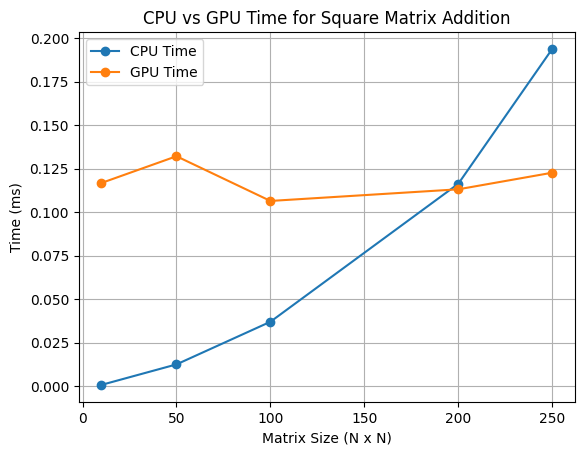

In [36]:
import matplotlib.pyplot as plt

# Matrix sizes (N x N)
N = [10, 50, 100, 200, 250]

# Time taken in milliseconds
cpu_time = [0.0007, 0.0125, 0.0370, 0.1163, 0.1938]
gpu_time = [0.116736, 0.132128, 0.106432, 0.113120, 0.122656]

# Plot
plt.figure()
plt.plot(N, cpu_time, marker='o', label='CPU Time')
plt.plot(N, gpu_time, marker='o', label='GPU Time')

plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Time (ms)')
plt.title('CPU vs GPU Time for Square Matrix Addition')
plt.legend()
plt.grid(True)

plt.show()


In [15]:
%%writefile matrix_mul.cpp
#include <iostream>
#include <chrono>
#include <iomanip>
using namespace std;
using namespace std::chrono;

int main() {
    int r, c;
    cin >> r >> c;   // square matrix assumed

    int A[r][c], B[r][c], C[r][c];

    // Init
    for(int i=0;i<r;i++)
        for(int j=0;j<c;j++)
            A[i][j]=5, B[i][j]=7, C[i][j]=0;

    auto start = high_resolution_clock::now();

    // Matrix multiplication
    for(int i=0;i<r;i++)
        for(int j=0;j<c;j++)
            for(int k=0;k<c;k++)
                C[i][j] += A[i][k] * B[k][j];

    auto end = high_resolution_clock::now();

    // Output (partial)
    for(int i=0;i<r && i<5;i++) {
        for(int j=0;j<c && j<5;j++)
            cout << C[i][j] << " ";
        cout << endl;
    }

    double time_ms = duration<double, milli>(end - start).count();

    cout << fixed << setprecision(6);
    cout << "CPU Time: " << time_ms << " ms\n";

    return 0;
}


Overwriting matrix_mul.cu


In [19]:
%%writefile matrix_mul.cu
#include <stdio.h>
#include <cuda.h>

__global__ void matMul(int *A, int *B, int *C, int r, int c) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < r && col < c) {
        int sum = 0;
        for (int k = 0; k < c; k++) {
            sum += A[row * c + k] * B[k * c + col];
        }
        C[row * c + col] = sum;
    }
}

int main() {
    int r, c;
    scanf("%d %d", &r, &c);   // same input as CPU

    if (r != c) {
        printf("Only square matrices supported\n");
        return 0;
    }

    int size = r * c * sizeof(int);

    // Host memory
    int *hA = (int*)malloc(size);
    int *hB = (int*)malloc(size);
    int *hC = (int*)malloc(size);

    for (int i = 0; i < r * c; i++) {
        hA[i] = 5;
        hB[i] = 7;
    }

    // Device memory
    int *dA, *dB, *dC;
    cudaMalloc(&dA, size);
    cudaMalloc(&dB, size);
    cudaMalloc(&dC, size);

    cudaMemcpy(dA, hA, size, cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, size, cudaMemcpyHostToDevice);

    dim3 threads(16, 16);
    dim3 blocks((c + 15) / 16, (r + 15) / 16);

    // ---- GPU timing (kernel only) ----
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matMul<<<blocks, threads>>>(dA, dB, dC, r, c);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float time_ms;
    cudaEventElapsedTime(&time_ms, start, stop);
    // ---------------------------------

    cudaMemcpy(hC, dC, size, cudaMemcpyDeviceToHost);

    // Output (partial, same as CPU)
    for (int i = 0; i < r && i < 5; i++) {
        for (int j = 0; j < c && j < 5; j++)
            printf("%d ", hC[i * c + j]);
        printf("\n");
    }

    printf("GPU Time: %.6f ms\n", time_ms);

    cudaFree(dA); cudaFree(dB); cudaFree(dC);
    free(hA); free(hB); free(hC);

    return 0;
}


Overwriting matrix_mul.cu


In [45]:
!g++ matrix_mul.cpp -O2 -o matrix_mul
!echo "60 60" | ./matrix_mul


2100 2100 2100 2100 2100 
2100 2100 2100 2100 2100 
2100 2100 2100 2100 2100 
2100 2100 2100 2100 2100 
2100 2100 2100 2100 2100 
CPU Time: 0.209281 ms


In [46]:
!nvcc -arch=sm_75 matrix_mul.cu -o matrix_mul
!echo "60 60" | ./matrix_mul


2100 2100 2100 2100 2100 
2100 2100 2100 2100 2100 
2100 2100 2100 2100 2100 
2100 2100 2100 2100 2100 
2100 2100 2100 2100 2100 
GPU Time: 0.103456 ms


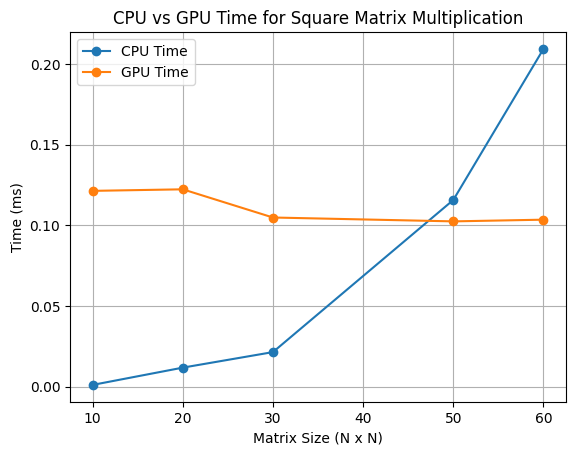

In [47]:
import matplotlib.pyplot as plt

# Matrix sizes (N x N)
N = [10, 20, 30, 50, 60]

# Time taken in milliseconds
cpu_time = [0.001042, 0.011754, 0.021385, 0.115666, 0.209281]
gpu_time = [0.121312, 0.122272, 0.104800, 0.102400, 0.103456]

# Plot
plt.figure()
plt.plot(N, cpu_time, marker='o', label='CPU Time')
plt.plot(N, gpu_time, marker='o', label='GPU Time')

plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Time (ms)')
plt.title('CPU vs GPU Time for Square Matrix Multiplication')
plt.legend()
plt.grid(True)

plt.show()


input
"10" "10"

CPU Time: 0.001042 ms

GPU Time: 0.121312 ms


input "20 20"

CPU Time: 0.011754 ms

GPU Time: 0.122272 ms

input "30 30"

CPU Time: 0.021385 ms

GPU Time: 0.104800 ms

input "50 50"

CPU Time: 0.115666 ms

GPU Time: 0.102400 ms

input "60 60"
CPU Time: 0.209281 ms

GPU Time: 0.103456 ms


In [ ]:
%%writefile matrix_add.cu
#include <stdio.h>
#include <cuda.h>

// CUDA Kernel for Matrix Addition
__global__ void matrixAdd(int *a, int *b, int *c, int rows, int cols) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int idy = threadIdx.y + blockIdx.y * blockDim.y;

    // Check bounds
    if (idx < cols && idy < rows) {
        int index = idy * cols + idx;
        c[index] = a[index] + b[index];
    }
}

int main() {
    int rows, cols;

    // User Input
    printf("Enter number of rows and columns: ");
    scanf("%d %d", &rows, &cols);

    int size = rows * cols * sizeof(int);

    // Allocate Host Memory
    int *h_a = (int*)malloc(size);
    int *h_b = (int*)malloc(size);
    int *h_c = (int*)malloc(size);

    // Initialize Matrices with some values (e.g., 1 and 2)
    for(int i = 0; i < rows * cols; i++) {
        h_a[i] = 1; // Filling Matrix A with 1s
        h_b[i] = 2; // Filling Matrix B with 2s
    }

    // Allocate Device Memory
    int *d_a, *d_b, *d_c;
    cudaMalloc((void**)&d_a, size);
    cudaMalloc((void**)&d_b, size);
    cudaMalloc((void**)&d_c, size);

    // Copy from Host to Device
    cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice);

    // Define Grid and Block dimensions
    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((cols + 15) / 16, (rows + 15) / 16);

    // Launch Kernel
    matrixAdd<<<blocksPerGrid, threadsPerBlock>>>(d_a, d_b, d_c, rows, cols);

    // Copy result back to Host
    cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);

    // Print Result (First 10 elements to verify)
    printf("\nResult Matrix (Partial View):\n");
    for(int i = 0; i < rows; i++) {
        for(int j = 0; j < cols; j++) {
            if(i < 5 && j < 5) printf("%d ", h_c[i * cols + j]);
        }
        if(i < 5) printf("\n");
    }

    // Free Memory
    free(h_a); free(h_b); free(h_c);
    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c);

    return 0;
}

Writing matrix_add.cu


Results =>

input 8 x 8


In [ ]:
!nvcc -arch=sm_75 matrix_add.cu -o matrix_add
!echo "3 3" | ./matrix_add

Enter number of rows and columns: 
Result Matrix (Partial View):
3 3 3 
3 3 3 
3 3 3 


In [ ]:
%%writefile matrix_mul.cu
#include <stdio.h>
#include <cuda.h>

// CUDA Kernel for Matrix Multiplication
__global__ void matrixMul(int *a, int *b, int *c, int rowsA, int colsA, int colsB) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rowsA && col < colsB) {
        int sum = 0;
        for (int k = 0; k < colsA; k++) {
            sum += a[row * colsA + k] * b[k * colsB + col];
        }
        c[row * colsB + col] = sum;
    }
}

int main() {
    int rowsA, colsA, rowsB, colsB;

    // User Input
    printf("Enter rows and columns for Matrix A: ");
    scanf("%d %d", &rowsA, &colsA);
    printf("Enter rows and columns for Matrix B: ");
    scanf("%d %d", &rowsB, &colsB);

    if (colsA != rowsB) {
        printf("Error: Columns of A must match Rows of B.\n");
        return -1;
    }

    // Allocate Host Memory
    int sizeA = rowsA * colsA * sizeof(int);
    int sizeB = rowsB * colsB * sizeof(int);
    int sizeC = rowsA * colsB * sizeof(int);

    int *h_a = (int*)malloc(sizeA);
    int *h_b = (int*)malloc(sizeB);
    int *h_c = (int*)malloc(sizeC);

    // Initialize Matrices
    for(int i = 0; i < rowsA * colsA; i++) h_a[i] = 2; // Matrix A = 2
    for(int i = 0; i < rowsB * colsB; i++) h_b[i] = 3; // Matrix B = 3

    // Allocate Device Memory
    int *d_a, *d_b, *d_c;
    cudaMalloc((void**)&d_a, sizeA);
    cudaMalloc((void**)&d_b, sizeB);
    cudaMalloc((void**)&d_c, sizeC);

    // Copy to Device
    cudaMemcpy(d_a, h_a, sizeA, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, sizeB, cudaMemcpyHostToDevice);

    // Launch Configuration
    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((colsB + 15) / 16, (rowsA + 15) / 16);

    matrixMul<<<blocksPerGrid, threadsPerBlock>>>(d_a, d_b, d_c, rowsA, colsA, colsB);

    // Copy Result Back
    cudaMemcpy(h_c, d_c, sizeC, cudaMemcpyDeviceToHost);

    // Print Result (Top-left corner)
    printf("\nResult Matrix (Partial View):\n");
    printf("Value should be 2 * 3 * %d = %d\n", colsA, 6 * colsA);
    for(int i = 0; i < rowsA && i < 5; i++) {
        for(int j = 0; j < colsB && j < 5; j++) {
            printf("%d ", h_c[i * colsB + j]);
        }
        printf("\n");
    }

    // Cleanup
    free(h_a); free(h_b); free(h_c);
    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c);

    return 0;
}

Writing matrix_mul.cu


In [ ]:
!nvcc -arch=sm_75 matrix_mul.cu -o matrix_mul
!echo "3 4 4 3" | ./matrix_mul

Enter rows and columns for Matrix A: Enter rows and columns for Matrix B: 
Result Matrix (Partial View):
Value should be 2 * 3 * 4 = 24
24 24 24 
24 24 24 
24 24 24 
